In [33]:
pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk

  Cloning https://github.com/mimoralea/gym-walk to /tmp/pip-install-tyqaf_yt/gym-walk_fcc79dee9d5c455b8ef4e2f286a2d67b
  Running command git clone --filter=blob:none --quiet https://github.com/mimoralea/gym-walk /tmp/pip-install-tyqaf_yt/gym-walk_fcc79dee9d5c455b8ef4e2f286a2d67b
  Resolved https://github.com/mimoralea/gym-walk to commit b915b94cf2ad16f8833a1ad92ea94e88159279f5
  Preparing metadata (setup.py) ... done


In [1]:
import warnings ; warnings.filterwarnings('ignore')

import itertools
import gym, gym_walk
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [3]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi

In [4]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [5]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [6]:
def print_action_value_function(Q,
                                optimal_Q=None,
                                action_symbols=('<', '>'),
                                prec=3,
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'err')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [7]:
def get_policy_metrics(env, gamma, pi, goal_state, optimal_Q,
                       n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    reached_goal, episode_reward, episode_regret = [], [], []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        episode_reward.append(0.0)
        episode_regret.append(0.0)
        while not done and steps < max_steps:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            episode_regret[-1] += regret

            state, reward, done, _ = env.step(action)
            episode_reward[-1] += (gamma**steps * reward)

            steps += 1

        reached_goal.append(state == goal_state)
    results = np.array((np.sum(reached_goal)/len(reached_goal)*100,
                        np.mean(episode_reward),
                        np.mean(episode_regret)))
    return results

In [8]:
def get_metrics_from_tracks(env, gamma, goal_state, optimal_Q, pi_track, coverage=0.1):
    total_samples = len(pi_track)
    n_samples = int(total_samples * coverage)
    samples_e = np.linspace(0, total_samples, n_samples, endpoint=True, dtype=np.int)
    metrics = []
    for e, pi in enumerate(tqdm(pi_track)):
        if e in samples_e:
            metrics.append(get_policy_metrics(
                env,
                gamma=gamma,
                pi=lambda s: pi[s],
                goal_state=goal_state,
                optimal_Q=optimal_Q))
        else:
            metrics.append(metrics[-1])
    metrics = np.array(metrics)
    success_rate_ma, mean_return_ma, mean_regret_ma = np.apply_along_axis(moving_average, axis=0, arr=metrics).T
    return success_rate_ma, mean_return_ma, mean_regret_ma

In [9]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [10]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [11]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values,
                                  min(len(valid_values), limit_items),
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v*({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)

    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset],
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

In [12]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

# Frozen Lake Environment

In [13]:
env = gym.make('FrozenLake-v1')
init_state = env.reset()
goal_state = 15
gamma = 0.99
n_episodes = 3000
P = env.env.P
n_cols, svf_prec, err_prec, avf_prec=9, 4, 2, 3
action_symbols=('<', 'v', '>', '^')
limit_items, limit_value = 5, 0.0
cu_limit_items, cu_limit_value, cu_episodes = 10, 0.0, 100

# Alpha and Epsilon schedules

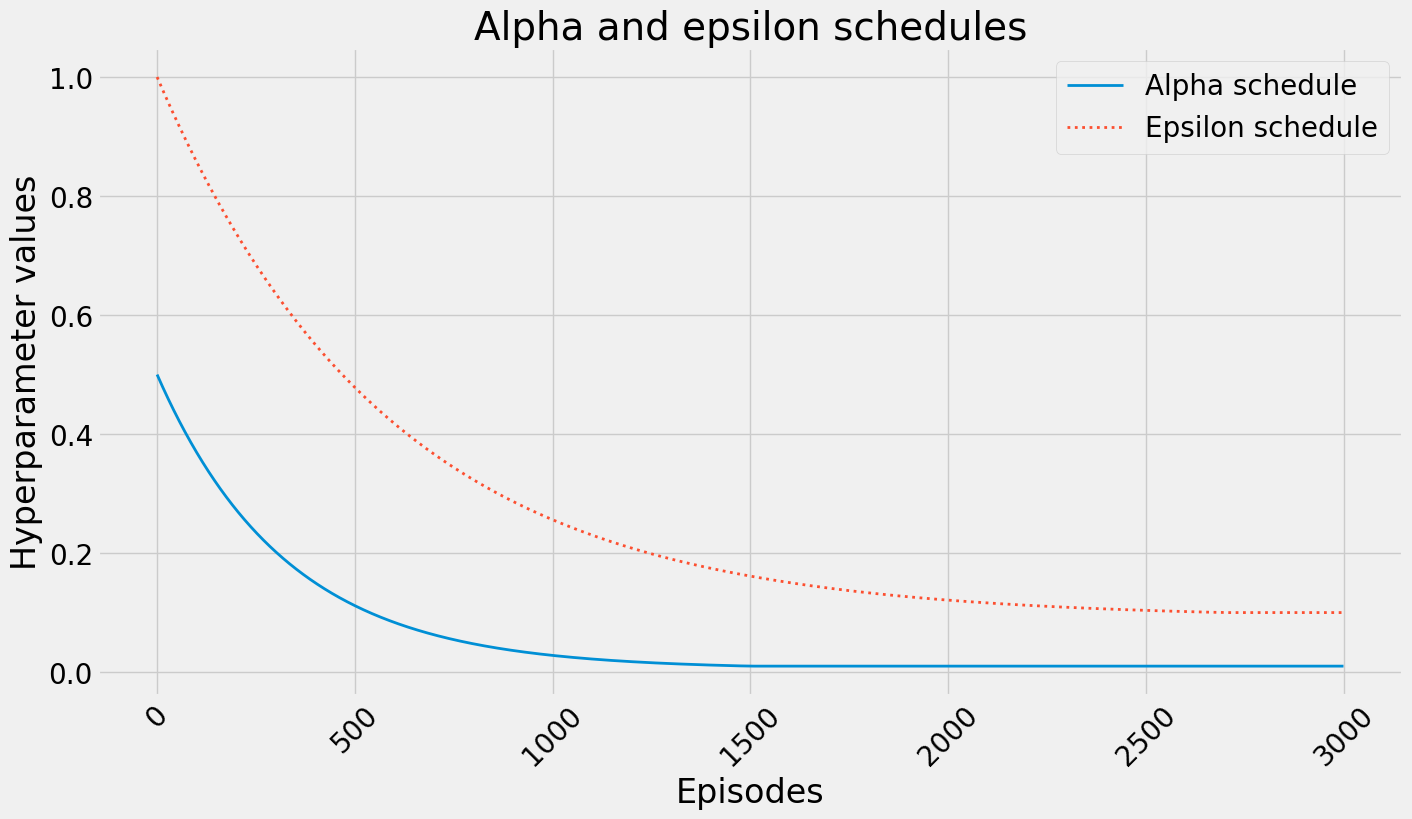

In [ ]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes),
         '-', linewidth=2,
         label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes),
         ':', linewidth=2,
         label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()

# Optimal value functions and policy

In [15]:
print("Name : Thiyagarajan A       Reg.no : 212222240110")
optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q,
                            None,
                            action_symbols=action_symbols,
                            prec=avf_prec,
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Name : Thiyagarajan A       Reg.no : 212222240110
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 | 04 0.5585 |           | 06 0.3583 |           | 08 0.5918 |
| 09 0.6431 | 10 0.6152 |           |           | 13 0.7417 | 14 0.8628 |           
Optimal action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╕
│   s │     < │     v │     > │     ^ │
╞═════╪═══════╪═══════╪═══════╪═══════╡
│   0 │ 0.542 │ 0.528 │ 0.528 │ 0.522 │
├─────┼───────┼───────┼───────┼───────┤
│   1 │ 0.343 │ 0.334 │ 0.32  │ 0.499 │
├─────┼───────┼───────┼───────┼───────┤
│   2 │ 0.438 │ 0.434 │ 0.424 │ 0.471 │
├─────┼───────┼───────┼───────┼───────┤
│   3 │ 0.306 │ 0.306 │ 0.302 │ 0.457 │
├─────┼───────┼───────┼───────┼───────┤
│   4 │ 0.558 │ 0.38  │ 0.374 │ 0.363 │
├─────┼───────┼───────┼───────┼───────┤
│   5 │ 0     │ 0     │ 0     │ 0     │
├─────┼───────┼───────┼───────┼───────┤
│   6 │ 0.358 │ 0.203 │ 0.358 │ 0.155 │
├─────┼───────┼───────┼───────┼───────┤
│   7 │ 0     

AttributeError: 'FrozenLakeEnv' object has no attribute 'seed'

# First-visit Monte-Carlo Control

In [16]:
def generate_trajectory(select_action, Q, epsilon, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, object)

In [17]:
def mc_control(env,
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=3000,
               max_steps=200,
               first_visit=True):
    nS, nA = env.observation_space.n, env.action_space.n
    discounts = np.logspace(0,
                            max_steps,
                            num=max_steps,
                            base=gamma,
                            endpoint=False)
    alphas = decay_schedule(init_alpha,
                           min_alpha,
                           alpha_decay_ratio,
                           n_episodes)
    epsilons = decay_schedule(init_epsilon,
                              min_epsilon,
                              epsilon_decay_ratio,
                              n_episodes)
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))

    for e in tqdm(range(n_episodes), leave=False):

        trajectory = generate_trajectory(select_action,
                                         Q,
                                         epsilons[e],
                                         env,
                                         max_steps)
        visited = np.zeros((nS, nA), dtype=np.bool)
        for t, (state, action, reward, _, _) in enumerate(trajectory):
            if visited[state][action] and first_visit:
                continue
            visited[state][action] = True

            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            Q[state][action] = Q[state][action] + alphas[e] * (G - Q[state][action])

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [18]:
Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = mc_control(env, gamma=gamma, n_episodes=n_episodes)
    Q_mcs.append(Q_mc) ; V_mcs.append(V_mc) ; Q_track_mcs.append(Q_track_mc)
Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)
del Q_mcs ; del V_mcs ; del Q_track_mcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

AttributeError: 'FrozenLakeEnv' object has no attribute 'seed'

In [19]:
print("Name : Thiyagarajan A       Reg.no : 212222240110")
print_state_value_function(V_mc, P, n_cols=n_cols,
                           prec=svf_prec, title='State-value function found by FVMC:')
print_state_value_function(optimal_V, P, n_cols=n_cols,
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=n_cols,
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc,
                            optimal_Q,
                            action_symbols=action_symbols,
                            prec=avf_prec,
                            title='FVMC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_mc, mean_return_mc, mean_regret_mc = get_policy_metrics(
    env, gamma=gamma, pi=pi_mc, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_mc, mean_return_mc, mean_regret_mc))

Name : Thiyagarajan A       Reg.no : 212222240110


NameError: name 'V_mc' is not defined

# Q-Learning

In [20]:
def q_learning(env,
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    select_action = lambda state,Q,epsilon: np.argmax(Q[state]) if np.random.random()>epsilon else np.random.randint(len(Q[state]))
    alphas=decay_schedule(init_alpha,min_alpha,alpha_decay_ratio,n_episodes)
    epsilons = decay_schedule(init_epsilon,min_epsilon,epsilon_decay_ratio,n_episodes)
    for e in tqdm(range(n_episodes),leave=False):
      state,done=env.reset(),False
      action=select_action(state,Q,epsilons[e])
      while not done:

        action=select_action(state,Q,epsilons[e])
        next_state,reward,done,_=env.step(action)
        td_target=reward+gamma*Q[next_state].max()*(not done)
        td_error=td_target-Q[state][action]
        Q[state][action]=Q[state][action]+alphas[e]*td_error
        state=next_state
      Q_track[e]=Q
      pi_track.append(np.argmax(Q,axis=1))
    V=np.max(Q,axis=1)
    pi=lambda s:{s:a for s,a in enumerate(np.argmax(Q,axis=1))}[s]
    return Q, V, pi, Q_track, pi_track



In [21]:
Q_qls, V_qls, Q_track_qls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_qls.append(Q_ql) ; V_qls.append(V_ql) ; Q_track_qls.append(Q_track_ql)
Q_ql = np.mean(Q_qls, axis=0)
V_ql = np.mean(V_qls, axis=0)
Q_track_ql = np.mean(Q_track_qls, axis=0)
del Q_qls ; del V_qls ; del Q_track_qls

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

AttributeError: 'FrozenLakeEnv' object has no attribute 'seed'

In [22]:
print("Name : Thiyagarajan A       Reg.no : 212222240110")
print_state_value_function(V_ql, P, n_cols=n_cols,
                           prec=svf_prec, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=n_cols,
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=n_cols,
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql,
                            optimal_Q,
                            action_symbols=action_symbols,
                            prec=avf_prec,
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_ql, mean_return_ql, mean_regret_ql = get_policy_metrics(
    env, gamma=gamma, pi=pi_ql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_ql, mean_return_ql, mean_regret_ql))

Name : Thiyagarajan A       Reg.no : 212222240110


NameError: name 'V_ql' is not defined

# Comparison

## First-visit Monte-Carlo

In [23]:
plot_value_function(
    'FVMC estimates through time vs. true values',
    np.max(Q_track_mc, axis=2),
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

NameError: name 'Q_track_mc' is not defined

## Q-learning

In [24]:
plot_value_function(
    'Q-Learning estimates through time vs. true values',
    np.max(Q_track_ql, axis=2),
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

NameError: name 'Q_track_ql' is not defined

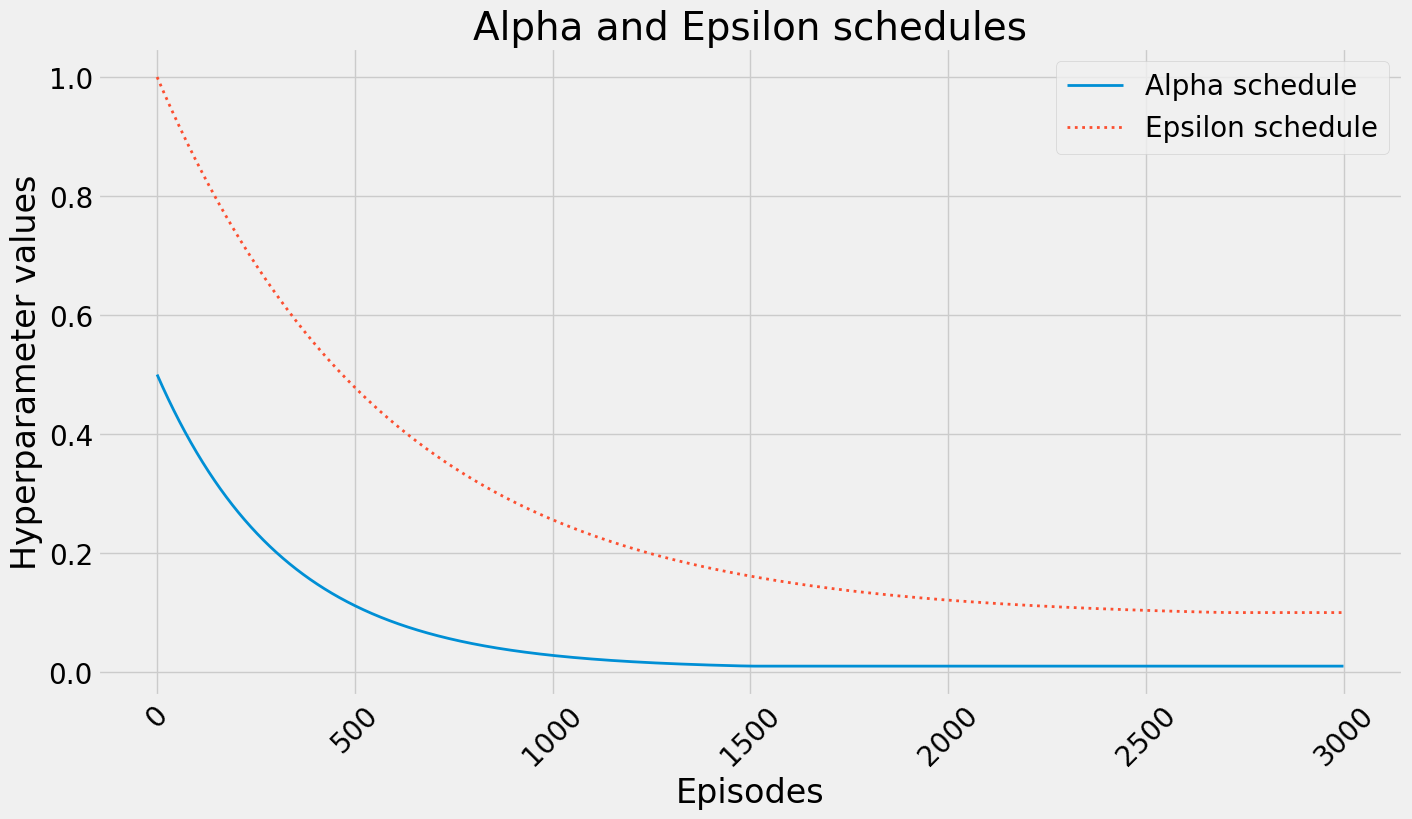

Name : Yuvaraj S       Reg.no : 212222240119

Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 | 04 0.5585 |           | 06 0.3583 |           | 08 0.5918 |
| 09 0.6431 | 10 0.6152 |           |           | 13 0.7417 | 14 0.8628 |           
Optimal action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╕
│   s │     < │     v │     > │     ^ │
╞═════╪═══════╪═══════╪═══════╪═══════╡
│   0 │ 0.542 │ 0.528 │ 0.528 │ 0.522 │
├─────┼───────┼───────┼───────┼───────┤
│   1 │ 0.343 │ 0.334 │ 0.32  │ 0.499 │
├─────┼───────┼───────┼───────┼───────┤
│   2 │ 0.438 │ 0.434 │ 0.424 │ 0.471 │
├─────┼───────┼───────┼───────┼───────┤
│   3 │ 0.306 │ 0.306 │ 0.302 │ 0.457 │
├─────┼───────┼───────┼───────┼───────┤
│   4 │ 0.558 │ 0.38  │ 0.374 │ 0.363 │
├─────┼───────┼───────┼───────┼───────┤
│   5 │ 0     │ 0     │ 0     │ 0     │
├─────┼───────┼───────┼───────┼───────┤
│   6 │ 0.358 │ 0.203 │ 0.358 │ 0.155 │
├─────┼───────┼───────┼───────┼───────┤
│   7 │ 0     │ 0 

Running FVMC for all seeds: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]



Name : Yuvaraj S       Reg.no : 212222240119

State-value function found by FVMC:
| 00 0.1401 | 01 0.1221 | 02 0.1255 | 03 0.0781 | 04 0.1549 |           | 06 0.1505 |           | 08 0.1971 |
| 09 0.2582 | 10 0.3201 |           |           | 13 0.3303 | 14 0.6349 |           Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 | 04 0.5585 |           | 06 0.3583 |           | 08 0.5918 |
| 09 0.6431 | 10 0.6152 |           |           | 13 0.7417 | 14 0.8628 |           State-value function errors:
| 00   -0.4 | 01  -0.38 | 02  -0.35 | 03  -0.38 | 04   -0.4 |           | 06  -0.21 |           | 08  -0.39 |
| 09  -0.38 | 10   -0.3 |           |           | 13  -0.41 | 14  -0.23 |           State-value function RMSE: 0.2941

FVMC action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │

Reaches goal 33.00%. Obtains an average return of 0.2563. Regret of 0.4294



Running Q-Learning for all seeds: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]



Name : Yuvaraj S       Reg.no : 212222240119

State-value function found by Q-Learning:
| 00 0.4703 | 01  0.385 | 02  0.314 | 03 0.1909 | 04 0.4864 |           | 06 0.2583 |           | 08 0.5177 |
| 09 0.5639 | 10 0.5198 |           |           | 13 0.6667 | 14 0.7942 |           Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 | 04 0.5585 |           | 06 0.3583 |           | 08 0.5918 |
| 09 0.6431 | 10 0.6152 |           |           | 13 0.7417 | 14 0.8628 |           State-value function errors:
| 00  -0.07 | 01  -0.11 | 02  -0.16 | 03  -0.27 | 04  -0.07 |           | 06   -0.1 |           | 08  -0.07 |
| 09  -0.08 | 10   -0.1 |           |           | 13  -0.07 | 14  -0.07 |           State-value function RMSE: 0.0999

Q-Learning action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v

Reaches goal 48.00%. Obtains an average return of 0.3577. Regret of 0.2134



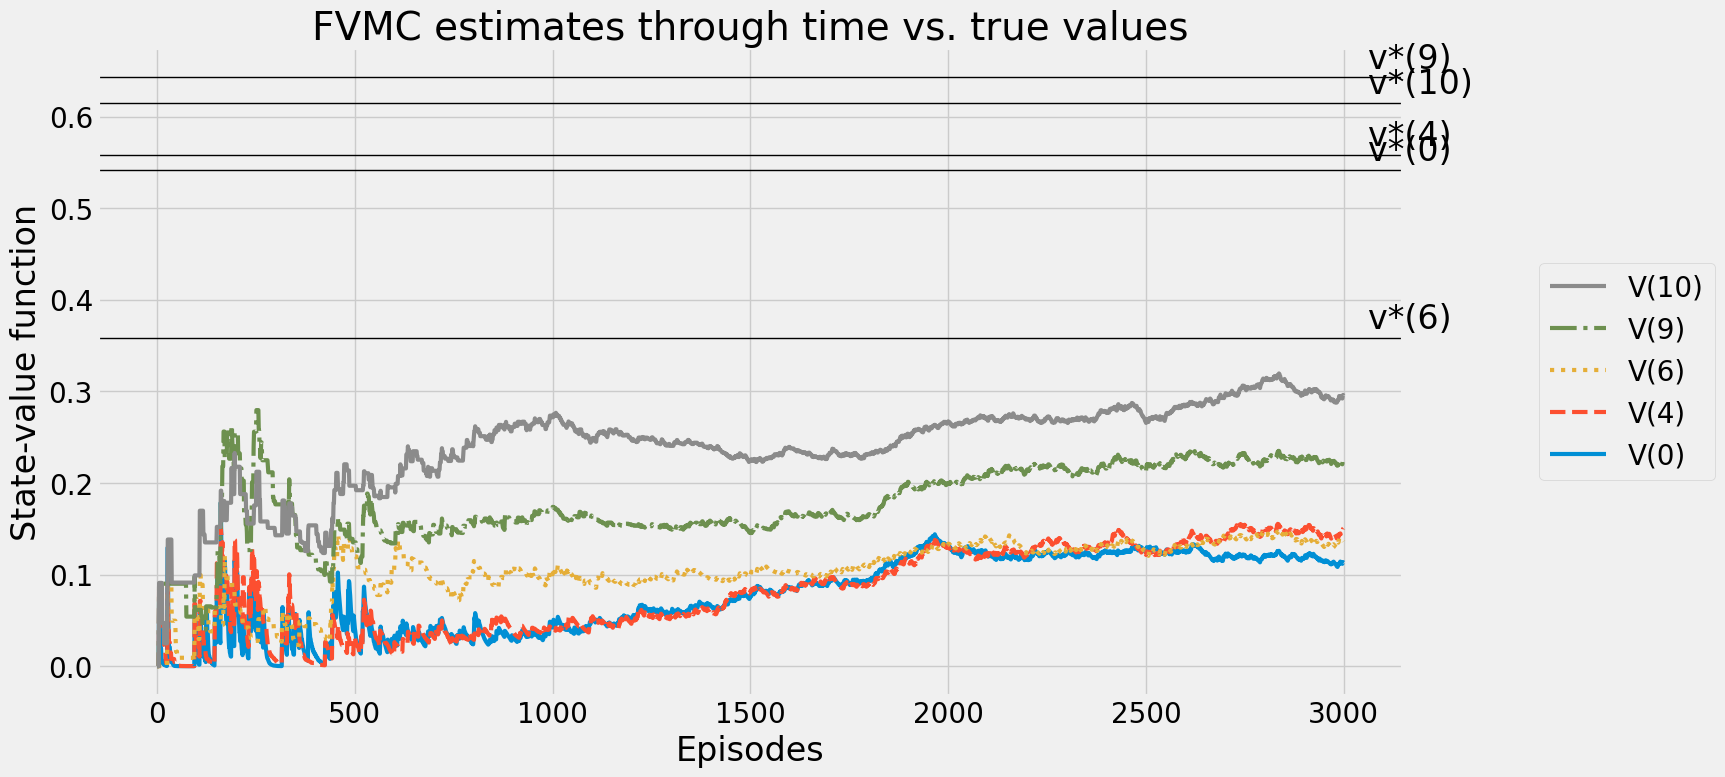

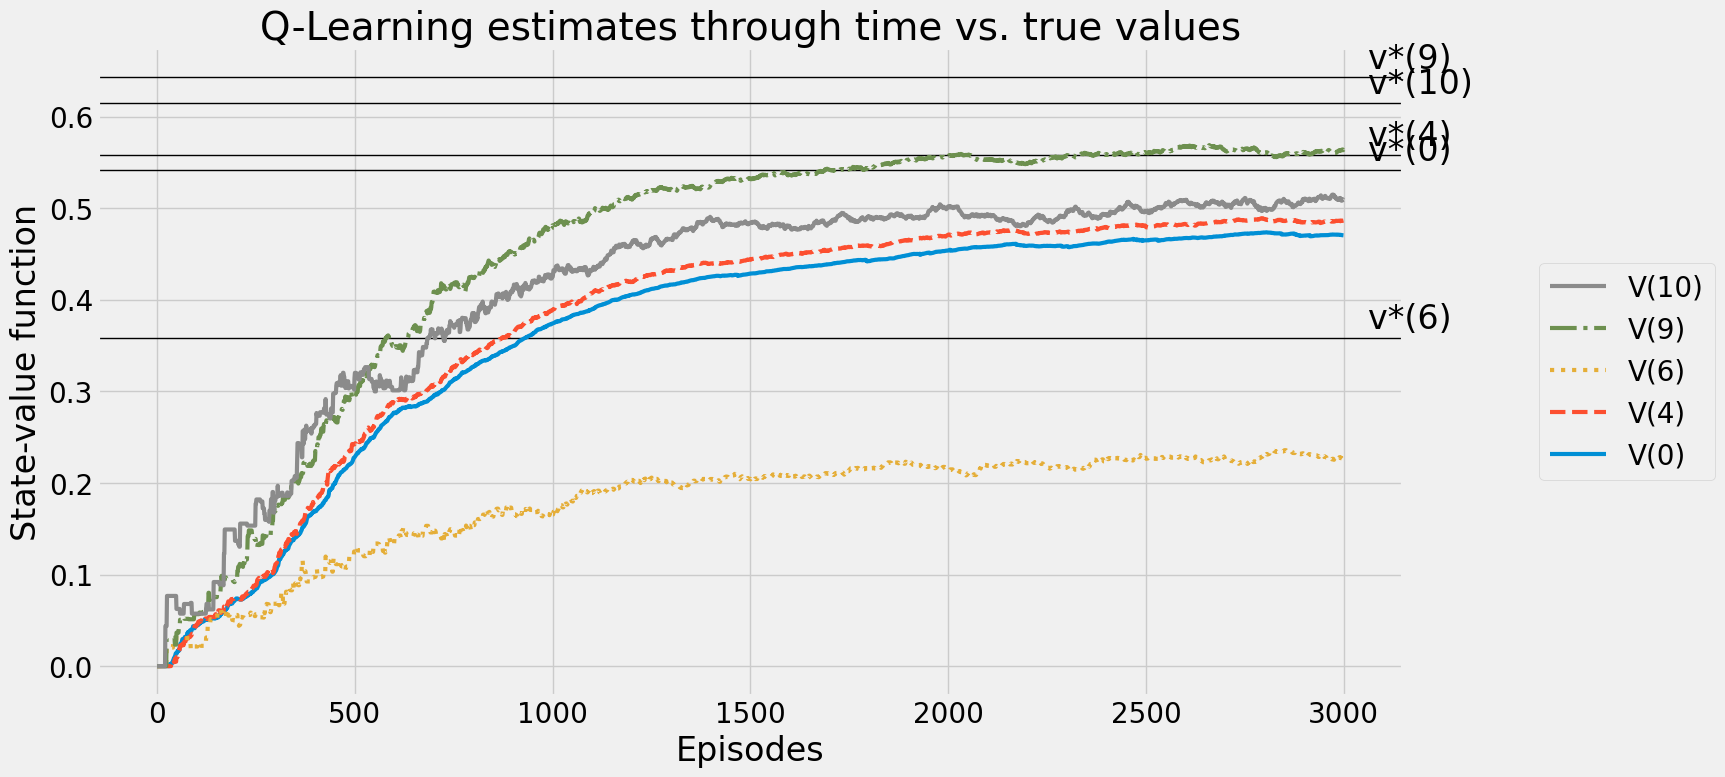

In [27]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import itertools
import gym, gym_walk
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# -------------------- Global Settings --------------------
SEEDS = (12, 34, 56, 78, 90)

plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)
random.seed(123)
np.random.seed(123)

# -------------------- Value Iteration --------------------
def value_iteration(P, gamma=1.0, theta=1e-10):
    """
    P: transition dict P[state][action] = list of (prob, next_state, reward, done)
    Returns: Q, V, pi
    """
    nS = len(P)
    nA = len(P[0])
    V = np.zeros(nS, dtype=np.float64)

    while True:
        Q = np.zeros((nS, nA), dtype=np.float64)
        for s in range(nS):
            for a in range(nA):
                for (prob, next_state, reward, done) in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        new_V = np.max(Q, axis=1)
        if np.max(np.abs(V - new_V)) < theta:
            break
        V = new_V.copy()

    pi = lambda s: int(np.argmax(Q[s]))
    return Q, V, pi

# -------------------- Printing Helpers --------------------
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k: v for k, v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for (_, _, _, done) in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0:
            print("|")

def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for (_, _, _, done) in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), f"{np.round(v, prec)}".rjust(6), end=" ")
        if (s + 1) % n_cols == 0:
            print("|")

def print_action_value_function(Q, optimal_Q=None, action_symbols=('<', '>'), prec=3, title='Action-value function:'):
    vf_types = ('',) if optimal_Q is None else ('', '*', 'err')
    headers = ['s'] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if optimal_Q is not None:
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q - Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

# -------------------- Policy Metrics --------------------
def get_policy_metrics(env, gamma, pi, goal_state, optimal_Q, n_episodes=100, max_steps=200):
    """
    Runs n_episodes using policy pi (a function s->a).
    Returns [success_rate%, average_gamma_return, average_regret].
    """
    reached_goal = []
    episode_reward = []
    episode_regret = []

    for ep in range(n_episodes):
        reset_return = env.reset()
        if isinstance(reset_return, tuple):
            state, _ = reset_return
        else:
            state = reset_return

        done = False
        steps = 0
        cum_reward = 0.0
        cum_regret = 0.0

        while not done and steps < max_steps:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            cum_regret += regret

            nxt_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            cum_reward += (gamma ** steps) * reward

            state = nxt_state
            steps += 1

        reached_goal.append(int(state == goal_state))
        episode_reward.append(cum_reward)
        episode_regret.append(cum_regret)

    success_rate = 100.0 * np.sum(reached_goal) / n_episodes
    avg_return = np.mean(episode_reward)
    avg_regret = np.mean(episode_regret)
    return success_rate, avg_return, avg_regret

# -------------------- Moving Average & RMSE --------------------
def moving_average(a, n=100):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y) ** 2)), dp)

# -------------------- Plot Helper --------------------
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_states = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_states,
                                  min(len(valid_states), limit_items),
                                  replace=False)

    if V_true is not None:
        for i in items_idxs:
            if V_true[i] < limit_value:
                continue
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(len(V_track)*1.02, V_true[i] + .01, f'v*({i})')

    for i in items_idxs:
        if V_track[-1, i] < limit_value:
            continue
        line_type = next(linecycler)
        label = f'V({i})'
        p, = plt.plot(V_track[:, i], line_type, linewidth=3, label=label)
        legends.append(p)

    legends.reverse()
    ls = []
    for idx in range(0, len(legends), per_col):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset],
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    for l in ls[:-1]:
        plt.gca().add_artist(l)

    if log:
        plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

# -------------------- Decay Schedule --------------------
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

# -------------------- Main Experiment --------------------
env = gym.make('FrozenLake-v1')
reset_return = env.reset()
if isinstance(reset_return, tuple):
    init_state, _ = reset_return
else:
    init_state = reset_return

goal_state = 15
gamma = 0.99
n_episodes = 3000
P = env.env.P

n_cols = 9
svf_prec, err_prec, avf_prec = 4, 2, 3
action_symbols = ('<', 'v', '>', '^')
limit_items, limit_value = 5, 0.0
cu_limit_items, cu_limit_value, cu_episodes = 10, 0.0, 100

# Plot Alpha/Epsilon schedules
plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes), '-', linewidth=2, label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes), ':', linewidth=2, label='Epsilon schedule')
plt.legend(loc=1, ncol=1)
plt.title('Alpha and Epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)
plt.show()

# Compute optimal policy via Value Iteration
optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)

print("Name : Yuvaraj S       Reg.no : 212222240119\n")
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print()
print_action_value_function(optimal_Q, None, action_symbols=action_symbols, prec=avf_prec, title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=action_symbols, n_cols=n_cols)

success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print(f"\nReaches goal {success_rate_op:.2f}%. Obtains an average return of {mean_return_op:.4f}. Regret of {mean_regret_op:.4f}\n")

# -------------------- First-Visit Monte Carlo Control --------------------
def generate_trajectory(select_action, Q, epsilon, env, max_steps=200):
    """
    Generates one episode (trajectory) using epsilon-greedy policy w.r.t. Q.
    Returns array of (state, action, reward, next_state, done).
    """
    reset_return = env.reset()
    if isinstance(reset_return, tuple):
        state, _ = reset_return
    else:
        state = reset_return

    trajectory = []
    for t in count():
        action = select_action(state, Q, epsilon)
        nxt_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        trajectory.append((state, action, reward, nxt_state, done))
        if done or t >= max_steps - 1:
            break
        state = nxt_state

    return np.array(trajectory, dtype=object)

def mc_control(env,
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=3000,
               max_steps=200,
               first_visit=True):
    """
    First-visit Monte Carlo control for FrozenLake.
    Returns Q_final, V_final, pi_final, Q_track, pi_track.
    """
    nS, nA = env.observation_space.n, env.action_space.n
    discounts = np.array([gamma ** i for i in range(max_steps)])
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    def select_action(state, Q, epsilon):
        if np.random.random() > epsilon:
            return int(np.argmax(Q[state]))
        else:
            return int(np.random.randint(nA))

    for e in tqdm(range(n_episodes), leave=False):
        epsilon = epsilons[e]
        alpha = alphas[e]

        trajectory = generate_trajectory(select_action, Q, epsilon, env, max_steps)
        visited = np.zeros((nS, nA), dtype=bool)

        for t, (state, action, reward, _, _) in enumerate(trajectory):
            if first_visit and visited[state][action]:
                continue
            visited[state][action] = True

            rest = trajectory[t:]
            rewards = np.array([step[2] for step in rest], dtype=np.float64)
            n_steps = len(rewards)
            G = np.dot(discounts[:n_steps], rewards)

            Q[state][action] += alpha * (G - Q[state][action])

        Q_track[e] = Q.copy()
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: int(np.argmax(Q[s]))
    return Q, V, pi, Q_track, pi_track

# Run MC Control over multiple seeds and average
Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm(SEEDS, desc='Running FVMC for all seeds'):
    random.seed(seed)
    np.random.seed(seed)
    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = mc_control(env, gamma=gamma, n_episodes=n_episodes)
    Q_mcs.append(Q_mc)
    V_mcs.append(V_mc)
    Q_track_mcs.append(Q_track_mc)

Q_mc = np.mean(Q_mcs, axis=0)
V_mc = np.mean(V_mcs, axis=0)
Q_track_mc = np.mean(Q_track_mcs, axis=0)

print(f"\nName : Yuvaraj S       Reg.no : 212222240119\n")
print_state_value_function(V_mc, P, n_cols=n_cols, prec=svf_prec, title='State-value function found by FVMC:')
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=n_cols, prec=err_prec, title='State-value function errors:')
print(f"State-value function RMSE: {rmse(V_mc, optimal_V)}\n")

print_action_value_function(Q_mc, optimal_Q, action_symbols=action_symbols, prec=avf_prec, title='FVMC action-value function:')
print(f"Action-value function RMSE: {rmse(Q_mc, optimal_Q)}\n")

# Final policy from last MC run
Q_last, _, pi_last, _, _ = mc_control(env, gamma=gamma, n_episodes=n_episodes)
success_rate_mc, mean_return_mc, mean_regret_mc = get_policy_metrics(env, gamma=gamma, pi=pi_last, goal_state=goal_state, optimal_Q=optimal_Q)
print(f"Reaches goal {success_rate_mc:.2f}%. Obtains an average return of {mean_return_mc:.4f}. Regret of {mean_regret_mc:.4f}\n")

# -------------------- Q-Learning --------------------
def q_learning(env,
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n

    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    pi_track = []

    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

    def select_action(state, Q, epsilon):
        if np.random.random() > epsilon:
            return int(np.argmax(Q[state]))
        else:
            return int(np.random.randint(nA))

    for e in tqdm(range(n_episodes), leave=False):
        reset_return = env.reset()
        if isinstance(reset_return, tuple):
            state, _ = reset_return
        else:
            state = reset_return

        epsilon = epsilons[e]
        alpha = alphas[e]

        done = False
        while not done:
            action = select_action(state, Q, epsilon)
            nxt_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            td_target = reward + gamma * np.max(Q[nxt_state]) * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            state = nxt_state

        Q_track[e] = Q.copy()
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: int(np.argmax(Q[s]))
    return Q, V, pi, Q_track, pi_track

# Run Q-Learning over multiple seeds and average
Q_qls, V_qls, Q_track_qls = [], [], []
for seed in tqdm(SEEDS, desc='Running Q-Learning for all seeds'):
    random.seed(seed)
    np.random.seed(seed)
    Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_qls.append(Q_ql)
    V_qls.append(V_ql)
    Q_track_qls.append(Q_track_ql)

Q_ql = np.mean(Q_qls, axis=0)
V_ql = np.mean(V_qls, axis=0)
Q_track_ql = np.mean(Q_track_qls, axis=0)

print(f"\nName : Yuvaraj S       Reg.no : 212222240119\n")
print_state_value_function(V_ql, P, n_cols=n_cols, prec=svf_prec, title='State-value function found by Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=n_cols, prec=err_prec, title='State-value function errors:')
print(f"State-value function RMSE: {rmse(V_ql, optimal_V)}\n")

print_action_value_function(Q_ql, optimal_Q, action_symbols=action_symbols, prec=avf_prec, title='Q-Learning action-value function:')
print(f"Action-value function RMSE: {rmse(Q_ql, optimal_Q)}\n")

_, _, pi_final_ql, _, _ = q_learning(env, gamma=gamma, n_episodes=n_episodes)
success_rate_ql, mean_return_ql, mean_regret_ql = get_policy_metrics(env, gamma=gamma, pi=pi_final_ql, goal_state=goal_state, optimal_Q=optimal_Q)
print(f"Reaches goal {success_rate_ql:.2f}%. Obtains an average return of {mean_return_ql:.4f}. Regret of {mean_regret_ql:.4f}\n")

# -------------------- Plot Comparisons --------------------
plot_value_function(
    'FVMC estimates through time vs. true values',
    np.max(Q_track_mc, axis=2),
    V_true=optimal_V,
    log=False,
    limit_items=limit_items,
    limit_value=limit_value
)

plot_value_function(
    'Q-Learning estimates through time vs. true values',
    np.max(Q_track_ql, axis=2),
    V_true=optimal_V,
    log=False,
    limit_items=limit_items,
    limit_value=limit_value
)
